![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Quick random forest gap-filling
</b>
</span>

---
**Notebook version**: `2` (25 Oct 2023)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)

</br>

# **Background**

- A simple random forest model is built and used for quick gap-filling
- Although this typically works well, this class is not meant for "final" gap-filling
- To speed up processing, the number of estimators is by default `20`

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [28]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [29]:
import importlib.metadata
import warnings

import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')
from datetime import datetime
from diive.configs.exampledata import load_exampledata_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.gapfilling.randomforest_ts import QuickFillRFTS

dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"This page was last modified on: {dt_string}")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

This page was last modified on: 2024-08-22 15:49:23
diive version: v0.79.0


</br>

# **Docstring** for `QuickFillRFTS`

In [30]:
help(QuickFillRFTS)

Help on class QuickFillRFTS in module diive.pkgs.gapfilling.randomforest_ts:

class QuickFillRFTS(builtins.object)
 |  QuickFillRFTS(df: pandas.core.frame.DataFrame, target_col: str)
 |  
 |  Quick gap-filling using RandomForestTS with pre-defined parameters
 |  
 |  The purpose of this class is preliminary gap-filling e.g. for quick tests
 |  how gap-filled data could look like. It is not meant to be used for
 |  final gap-filling.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df: pandas.core.frame.DataFrame, target_col: str)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fill(self)
 |  
 |  gapfilling_df(self)
 |  
 |  get_flag(self) -> pandas.core.series.Series
 |  
 |  get_gapfilled_target(self) -> pandas.core.series.Series
 |  
 |  report(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  _

</br>

# **Load data**

## Load example data from pickle file

In [31]:
df = load_exampledata_parquet()

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.029 seconds). Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [32]:
lowquality = df[
                 "QCF_NEE"] > 0  # This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only

In [33]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,41284.000000,175296.000000,175296.000000,175296.000000
mean,-3.833522,4.712999,3.233176,152.671445
std,6.085449,7.548653,3.710180,247.531312
min,-38.653000,-23.096000,0.000000,0.000000
25%,-7.840000,-0.800000,0.661000,0.000000
50%,-3.827000,4.600000,1.991000,2.596000
75%,0.606250,10.067000,4.375000,225.677750
max,25.290000,28.713000,32.118000,1197.800000


In [34]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2013-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,3651 days 23:30:00
NOV,41284
MISSING,134012
MISSING_PERC,76.448978
MEAN,-3.833522
MEDIAN,-3.827
SD,6.085449
VAR,37.032694


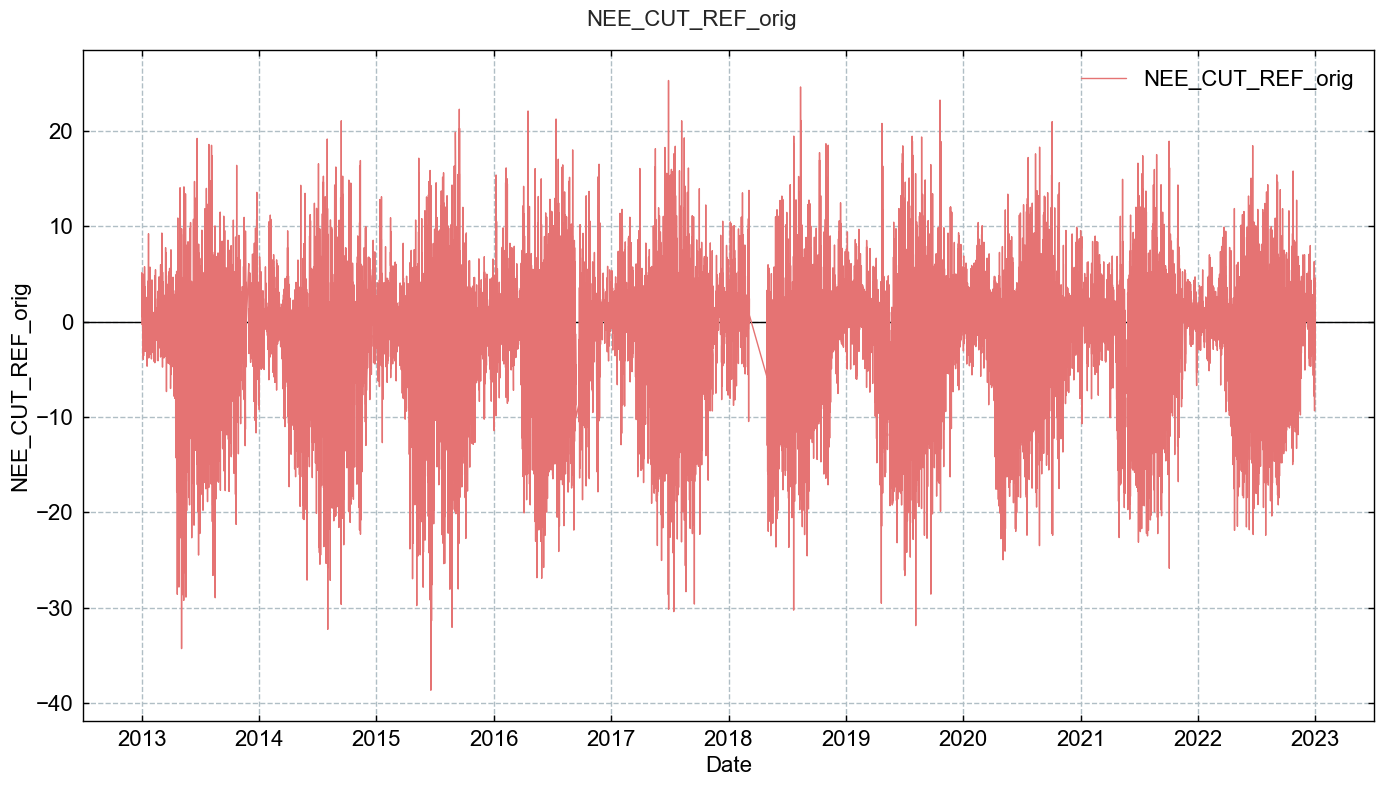

In [35]:
# TimeSeries(series=df[TARGET_COL]).plot_interactive()
TimeSeries(series=df[TARGET_COL]).plot()

</br>

</br>

# **Gap-filling**

In [36]:
qf = QuickFillRFTS(df=df, target_col=TARGET_COL)
qf.fill()
gapfilled = qf.get_gapfilled_target()


Adding new data columns ...
++ Added new columns with lagged variants for: ['Tair_f', 'VPD_f', 'Rg_f'] (lags between -1 and -1 with stepsize 1), no lagged variants for: ['NEE_CUT_REF_orig'].
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 175296.

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
>>> All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
>>> Sorting timestamp TIMESTAMP_MIDDLE ascending ...
>>> Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
>>> Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ...

Training final model ...
>>> Training model <class 'sklearn.en

In [37]:
qf.report()


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (134011 values, NEE_CUT_REF_orig_gfRF where flag=1) in comparison to observed targets (41284 values, NEE_CUT_REF_orig).

## TARGET
- first timestamp:  2013-01-01 00:15:00
- last timestamp:  2022-12-31 23:45:00
- potential number of values: 175296 values)
- target column (observed):  NEE_CUT_REF_orig
- missing records (observed):  134012 (cross-check from flag: 134012)
- target column (gap-filled):  NEE_CUT_REF_orig_gfRF  (175296 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED
  > flag 0 ... observed targets (41284 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (134011 values)
  > flag 2 ... targets gap-filled with fallback (1 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['Rg_f', '.DOY', '.Tair_f-1', '.HOUR', 'Tair_f', '.Rg_f-1', '.VPD_f-1', 'VPD_f', '.RECORDNUMBER', '

</br>

## **Plot**

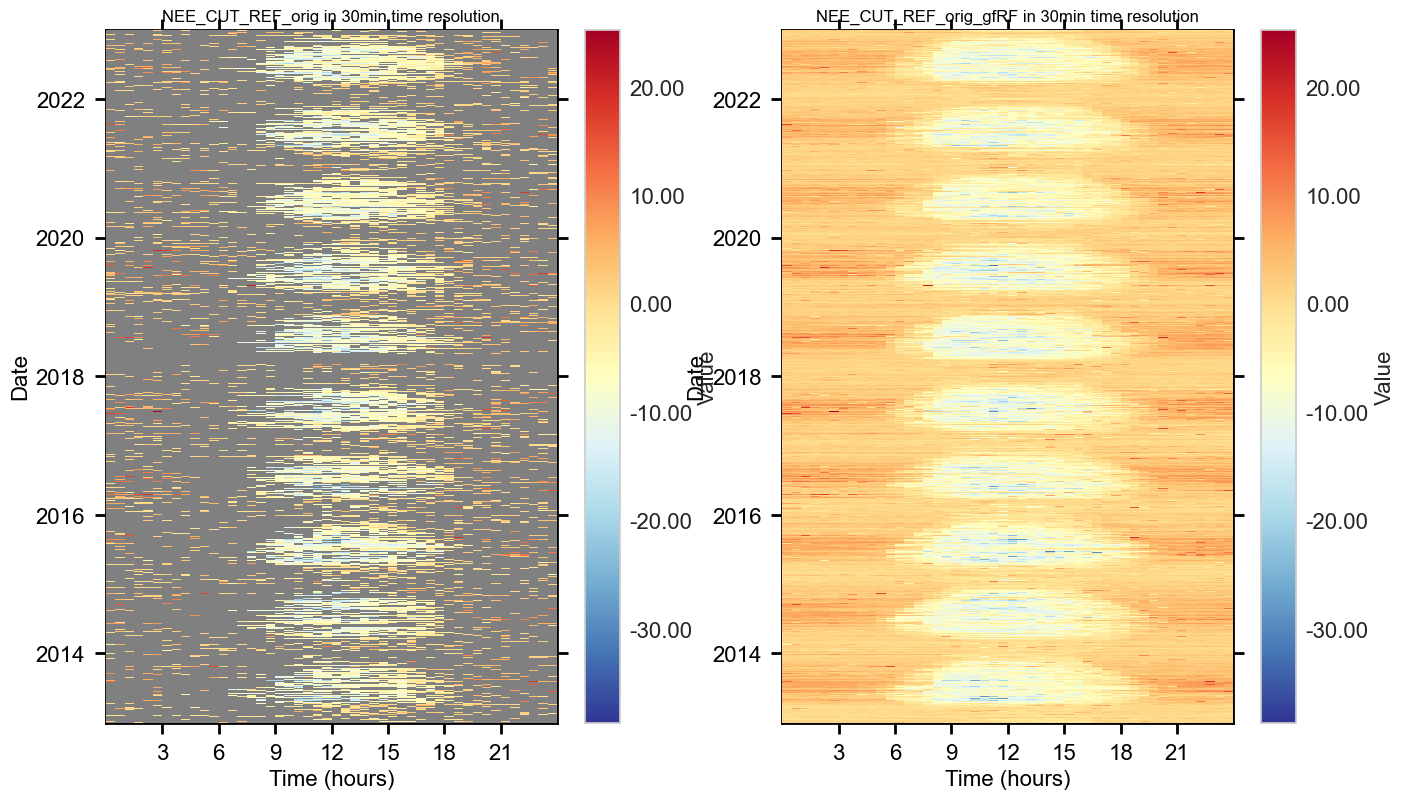

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 9))
HeatmapDateTime(series=df[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gapfilled, ax=axs[1]).plot()

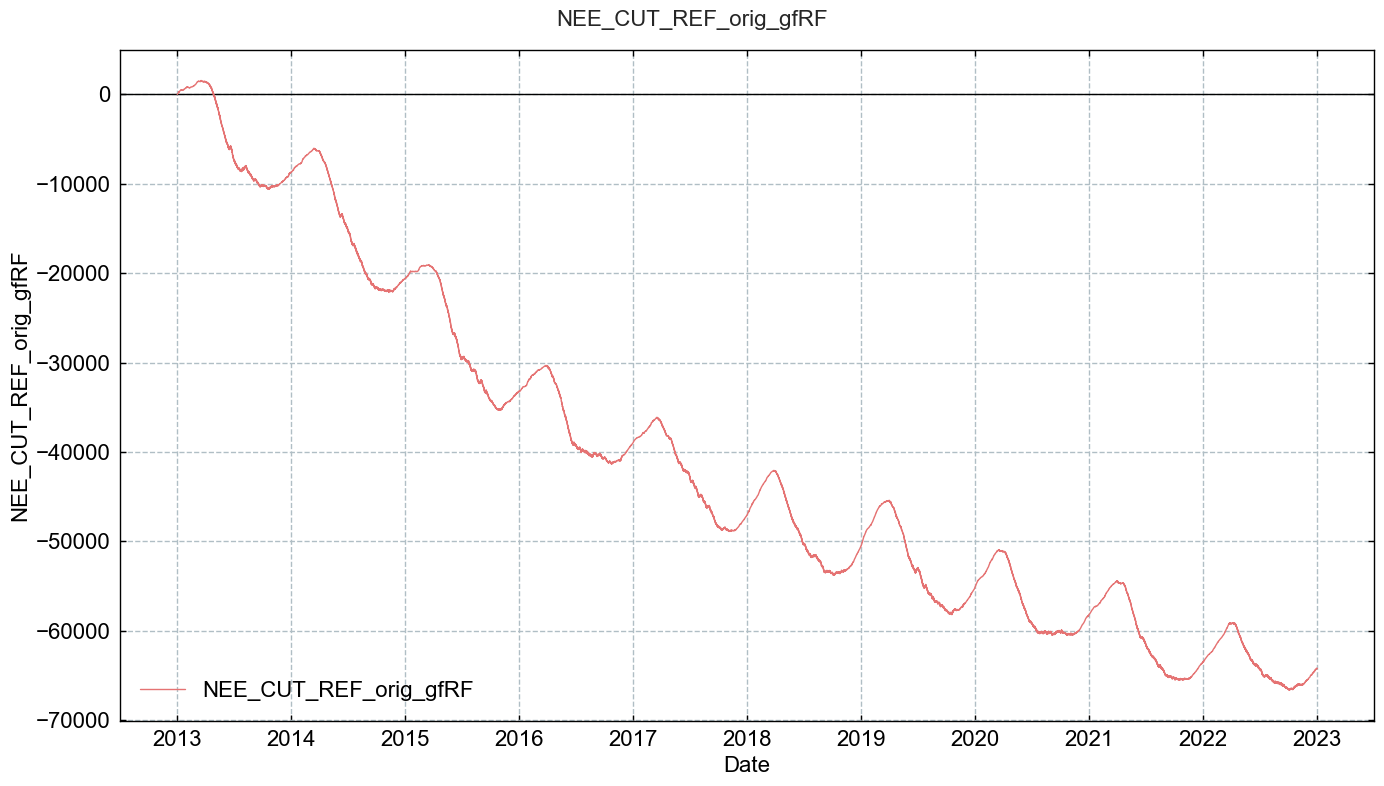

In [39]:
TimeSeries(series=gapfilled.cumsum()).plot()

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [40]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-08-22 15:49:55
